In [1]:
google_colab_flag = True # Make it False if do not intend to use Google Colab and want to train in local machine!!

# For training in Google Colab
if(google_colab_flag):
  from google.colab import drive
  drive.mount('/content/drive')
  !ls
  import sys
  root_path = '/content/drive/MyDrive/Research/' # This is the path to where in google drive the code is stored!
  sys.path.append(root_path)

# For local training
else:
  root_path = ''

Mounted at /content/drive
drive  sample_data


In [2]:
import zipfile
with zipfile.ZipFile(root_path + "Dataset.zip","r") as zip_ref:
  zip_ref.extractall(root_path + "")

In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
datasetFolderName = root_path + 'Dataset'

train_path = datasetFolderName+'/train/'
valid_path = datasetFolderName+'/valid/'
test_path = datasetFolderName+'/test/'

## Classes
- The name of the classes used in the dataset:

| Name ||
| --- | --- |
| light |
| moderate |
| no |
| severe |

## Data Generator

In [5]:
batch_size = 32
img_size = 224

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = train_datagen.flow_from_directory(train_path,  
                                                    target_size=(img_size, img_size), 
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    subset='training')  

valid_generator = train_datagen.flow_from_directory(train_path,  
                                                    target_size=(img_size, img_size), 
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    subset='validation')  

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(img_size, img_size),
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 180 images belonging to 4 classes.


## ConvNet Model (Pretrained MobileNet)
* Keep the learning rate as small as possible because the new trained weights should be close the weights previously learnt to identify features of this use case

### Model Definition and Hyperparameter Settings

In [6]:
mobilenet = MobileNet(input_shape = (img_size,img_size,3), weights='imagenet', include_top=False)

mobilenet.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenet.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet.layers[:fine_tune_at]:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(mobilenet.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)

prediction = Dense(4, activation='softmax')(x)

# create a model object
model = Model(inputs=mobilenet.input, outputs=prediction)

# tell the model what cost and optimization method to use
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

17235968/17225924 [==============================] - 0s 0us/step
Number of layers in the base model:  86


### Model Checkpoints
- Reduce the learning rate if the validation loss does not decrease after 5 successive epochs
- Stop the training if the validation loss does not decrease after 10 successive epochs
- Save the best model if it has a better validation loss than before

In [7]:
model_name = root_path + "model.h5"

checkpoint = ModelCheckpoint(model_name,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0, 
                              patience = 10, 
                              verbose = 1, 
                              restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0000001)

### Model Training

In [8]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=valid_generator,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 4.3781 - accuracy: 0.3956
Epoch 1: val_loss improved from inf to 1.35477, saving model to /content/drive/MyDrive/Research/model.h5
50/50 [==============================] - 42s 563ms/step - loss: 4.3781 - accuracy: 0.3956 - val_loss: 1.3548 - val_accuracy: 0.2825 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 1.1221 - accuracy: 0.4956
Epoch 2: val_loss improved from 1.35477 to 1.28974, saving model to /content/drive/MyDrive/Research/model.h5
50/50 [==============================] - 27s 547ms/step - loss: 1.1221 - accuracy: 0.4956 - val_loss: 1.2897 - val_accuracy: 0.3725 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 1.0641 - accuracy: 0.5494
Epoch 3: val_loss improved from 1.28974 to 1.25016, saving model to /content/drive/MyDrive/Research/model.h5
50/50 [==============================] - 27s 539ms/step - loss: 1.0641 - accuracy: 0.5494 - val_loss: 1.2

### Learning Curves

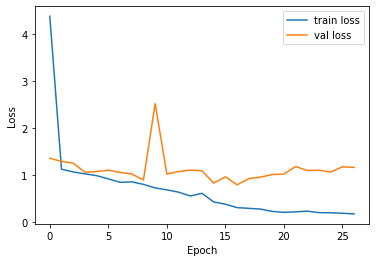

In [9]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#fig.savefig(root_path + 'loss curve', dpi=3000)

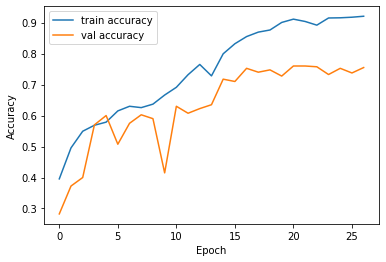

In [10]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#fig.savefig(root_path + 'accuracy curve', dpi=3000)

**Confusion matrix**

6/6 [==============================] - 1s 197ms/step


<Figure size 432x288 with 0 Axes>

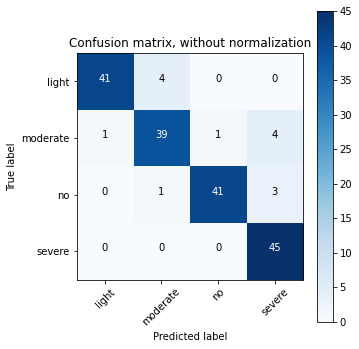

<Figure size 432x288 with 0 Axes>

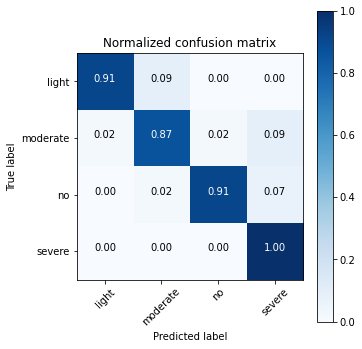

In [11]:
from sklearn.metrics import confusion_matrix
import itertools

Y_pred = model.predict(test_generator, verbose=1)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_true = test_generator.classes, y_pred = np.argmax(Y_pred, axis = -1))
class_names = ['light', 'moderate', 'no', 'severe']
      
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()
#fig.savefig(root_path + 'confusion_matrix_0', dpi=3000) 

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
#fig.savefig(root_path + 'confusion_matrix_1', dpi=3000)

**ROC curve**

6/6 [==============================] - 1s 119ms/step


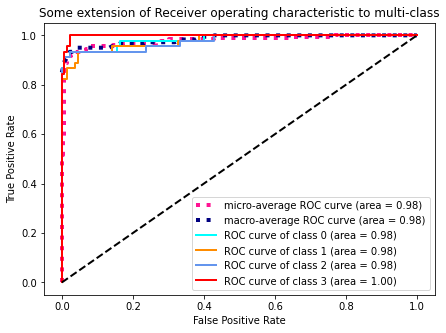

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

true_classes = test_generator.classes
y_true1 = label_binarize(true_classes,classes=[0,1,2,3])    
predictions = model.predict(test_generator, verbose=1)

fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()
n_classes = y_true1.shape[1]
for k in range(n_classes):
    fpr[k], tpr[k], thresholds[k] = roc_curve(y_true1[:,k], predictions[:,k], drop_intermediate=False)
    roc_auc[k] = auc(fpr[k], tpr[k])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true1.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
   
all_fpr = np.unique(np.concatenate([fpr[k] for k in range(n_classes)]))
    
mean_tpr = np.zeros_like(all_fpr)
for k in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[k], tpr[k])
    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
          color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
          color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for k, color in zip(range(n_classes), colors):
    plt.plot(fpr[k], tpr[k], color=color, lw=lw,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(k, roc_auc[k]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
#fig.savefig(root_path + 'Some extension of Receiver operating characteristic to multi-class', dpi=3000)

### Model Evalutation

In [13]:
from sklearn.metrics import classification_report

In [14]:
y_test = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred,axis=1)

In [15]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        45
           1       0.89      0.87      0.88        45
           2       0.98      0.91      0.94        45
           3       0.87      1.00      0.93        45

    accuracy                           0.92       180
   macro avg       0.93      0.92      0.92       180
weighted avg       0.93      0.92      0.92       180



In [16]:
class_indices = test_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [17]:
filenames = test_generator.filenames

In [18]:
test_df = pd.DataFrame()
test_df['filename'] = filenames
test_df['actual'] = y_test
test_df['predicted'] = y_pred
test_df['actual'] = test_df['actual'].apply(lambda x: indices[x])
test_df['predicted'] = test_df['predicted'].apply(lambda x: indices[x])
test_df.loc[test_df['actual']==test_df['predicted'],'Same'] = True
test_df.loc[test_df['actual']!=test_df['predicted'],'Same'] = False
test_df.head(10)

,filename,actual,predicted,Same
0,light/image_1.png,light,light,True
1,light/image_10.png,light,light,True
2,light/image_100.png,light,light,True
3,light/image_105.png,light,light,True
4,light/image_108.png,light,light,True
5,light/image_113.png,light,light,True
6,light/image_116.png,light,light,True
7,light/image_117.png,light,light,True
8,light/image_121.png,light,light,True
9,light/image_124.png,light,light,True


In [19]:
test_df = test_df.sample(frac=1).reset_index(drop=True)

## Grad-CAM

"Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say 'dog' in a classification network or a sequence of words in captioning network) flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept." **- Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization** (Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra)

- Derivative of the class with the highest probability returned by the softmax layer is taken with respect to the final convolutional layer to produce a heat map which highlights the important regions in the image that activated the class.
- For full mathematical details please check out this paper: https://arxiv.org/abs/1610.02391

### Image Visualization
- Correctly Classified (A and P are same)
- Misclassified (A and P are different)
- A: Actual P: Predicted

In [30]:
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20, 20))
    n = 0
    for i in range(10):
        n+=1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Research/Dataset/test/{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

### Correctly Classified

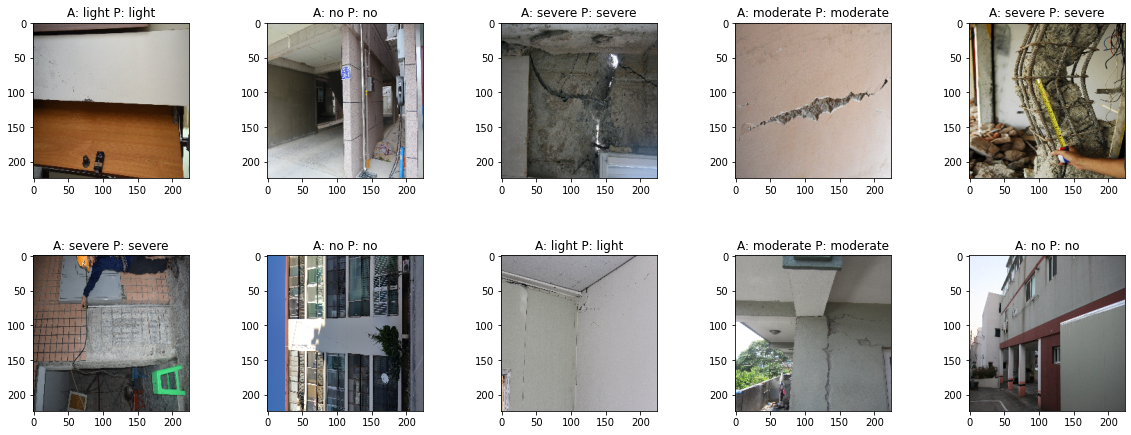

In [31]:
display_images(test_df[test_df['Same']==True])

### Misclassified

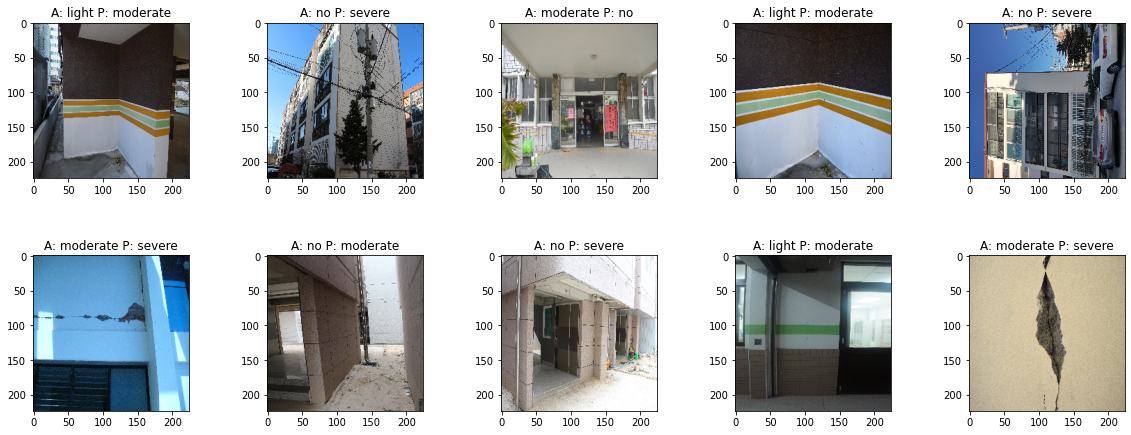

In [32]:
display_images(test_df[test_df['Same']!=True])

### Grad-CAM Computation
- Gradient computed of the final softmax layer with respect to the last convolution layer
- The fourth last layer of our model is the final convolutional block in our VGG-16 finetuned architecture
- Mean of the gradients is then multiplied to the last convolution layer's output 
- The output is then passed through a relu function to ensure that all values are positive

In [33]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    
    grad_model = Model(inputs=model.inputs, outputs=[model.layers[-5].output, model.output])  # need to change output layer: model.layers[-5].output

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

In [34]:
import matplotlib.cm as cm

In [35]:
test_df

,filename,actual,predicted,Same
0,light/image_117.png,light,light,True
1,no/image_62.png,no,no,True
2,severe/image_12.png,severe,severe,True
3,moderate/image_94.png,moderate,moderate,True
4,severe/image_27.png,severe,severe,True
...,...,...,...,...
175,moderate/image_92.png,moderate,moderate,True
176,no/image_157.png,no,no,True
177,severe/image_67.png,severe,severe,True
178,moderate/image_85.png,moderate,severe,False


### Grad-CAM Projection
- The heatmap produced using the Grad-CAM computation is then projected on to the original image
- The heatmap highlights the important parts of the image that lead to the activation of a class in the final softmax layer

In [36]:
def gradCAMImage(image):
    path = f"/content/drive/MyDrive/Research/Dataset/test/{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,model)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

## Results

In [39]:
def gradcam_of_images(correct_class):
    grad_images = []
    title = []
    temp_df = test_df[test_df['Same']==correct_class]
    temp_df = temp_df.reset_index(drop=True)
    for i in range(10):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")

    return grad_images, title

In [40]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
misclassified, m_titles = gradcam_of_images(correct_class=False)

In [41]:
def display_heatmaps(classified_images,titles):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(10):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    plt.show()

### Grad-CAM: Correctly Classified

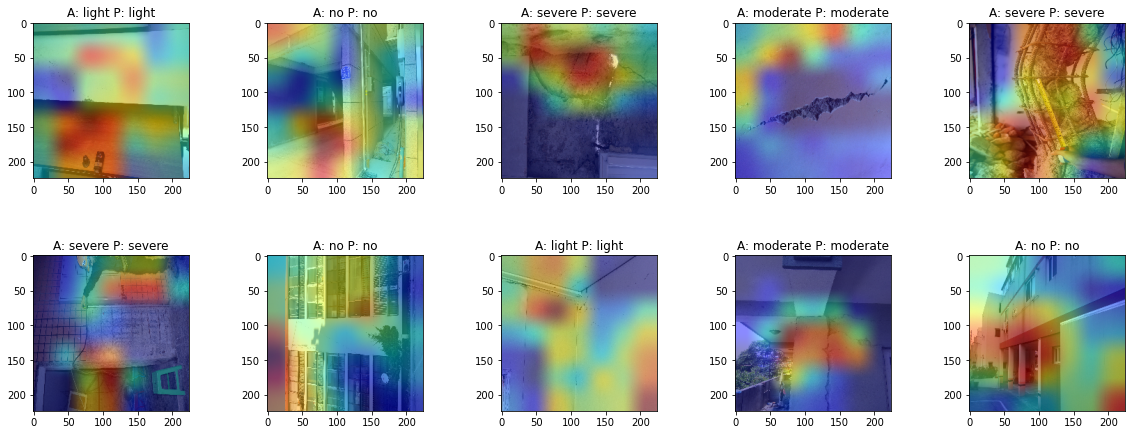

In [42]:
display_heatmaps(correctly_classified,c_titles)

### Grad-CAM: Incorrectly Classified

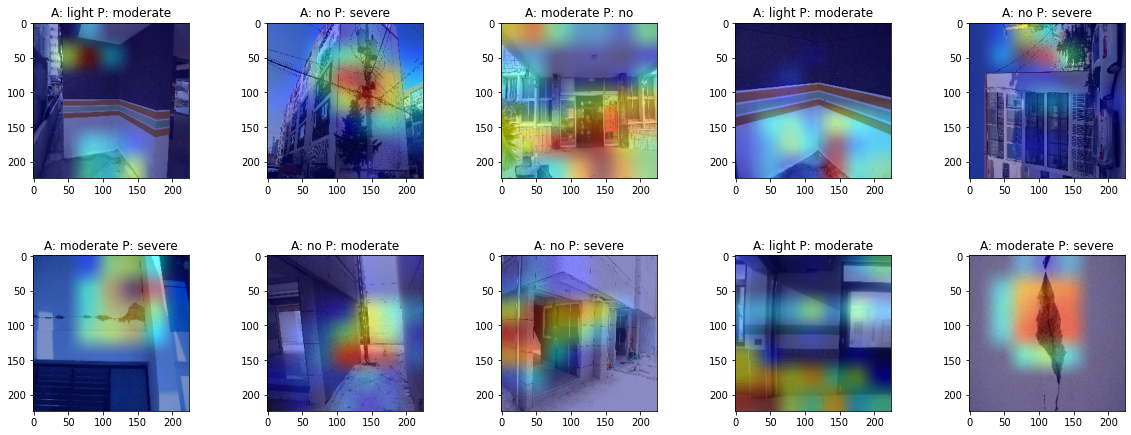

In [43]:
display_heatmaps(misclassified,m_titles)

## Conclusion

The aim of this notebook was to demonstrate the Grad-CAM method and how it can be used to interpret the CNNs. Inferences from the the Grad-CAM visualizations can be used to further improve the model misclassifications and boost model performance

https://www.kaggle.com/code/quadeer15sh/grad-cam-what-do-cnns-see